# Biraj Shrestha(Ace079bct024)

# Lab 3:Binary Classification with Neural Networks
## Objectives:
- To build, train, evaluate, and compare multiple Artificial Neural Network (ANN) architectures using PyTorch to classify a circular binary dataset
- To analyze how network depth, width, and activation functions affect performance on a non-linear classification problem.


## Theory:

##### <u>Binary Classification with a Neural Network</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Binary classification is a supervised learning problem where the goal is to assign input data into one of two classes. In this experiment, a neural network is used to classify circular data points into two categories.<br>

##### <u>Artificial Neural Network(ANN)</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;An Artificial Neural Network (ANN) is composed of layers of neurons. Each neuron performs a linear transformation followed by an optional non-linear activation function. Mathematically:

$$
z = Wx + b
$$

where  

$W$ represents weights,  

$x$ represents inputs, and  

$b$ is bias.

For binary classification, the model outputs a single value called a logit. This logit is converted into a probability using the sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

The model is trained using Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss), which combines sigmoid activation and cross-entropy loss for numerical stability. Parameter updates are performed using Stochastic Gradient Descent (SGD) to minimize the loss.

Since the circles dataset is non-linearly separable, linear models alone cannot correctly classify the data. Introducing hidden layers and non-linear activation functions such as ReLU allows the network to learn complex decision boundaries. Therefore, deeper networks with activation functions perform significantly better on non-linear classification tasks.

## Tasks:
#### Step 1: Data Retrieval and Inspection

In [ ]:
#data Retrieval and inspection
import pandas as pd

# Load dataset
df = pd.read_csv("circles_binary_classification.csv")

# Inspect
print(df.head())
print(df.describe())
print(df.info())

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
                X1           X2       label
count  1000.000000  1000.000000  1000.00000
mean     -0.000448    -0.000804     0.50000
std       0.639837     0.641156     0.50025
min      -1.059502    -1.067768     0.00000
25%      -0.619251    -0.612176     0.00000
50%       0.008762    -0.003949     0.50000
75%       0.621933     0.624822     1.00000
max       1.033712     1.036004     1.00000
<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1000 non-null   float64
 1   X2      1000 non-null   float64
 2   label   1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB
None


#### Step 2: Data Cleaning And Feature Design

In [3]:
# Data cleaning and feature design
# Check missing values
print(df.isnull().sum())

# Feature selection
X = df[["X1", "X2"]].values
y = df["label"].values

X1       0
X2       0
label    0
dtype: int64


In [4]:
import torch
import numpy as np

torch.manual_seed(42)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

#### Step 3: Data Visualization

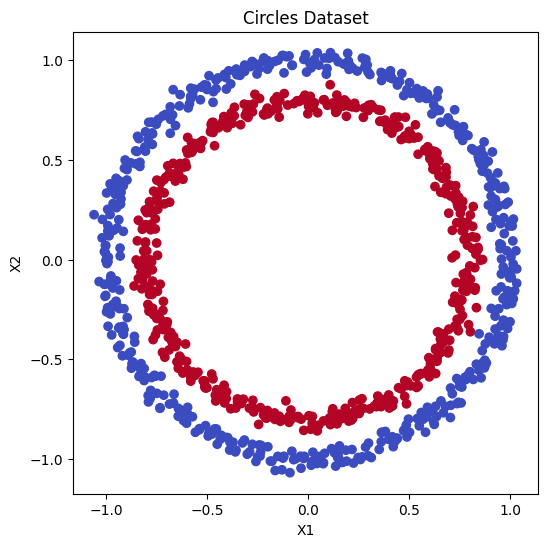

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(df["X1"], df["X2"], c=df["label"], cmap="coolwarm")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Circles Dataset")
plt.show()

#### Step 4: Train/Test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Step 5: Device and Dtype Setup

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

#### Step 6: Define Models
&nbsp;&nbsp;&nbsp;&nbsp;- ModelV0: 2 → 5 → 1 (No Activation)


In [8]:
import torch.nn as nn

class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 5)
        self.layer2 = nn.Linear(5, 1)
    
    def forward(self, x):
        return self.layer2(self.layer1(x))

&nbsp; - ModelV1: 2 → 15 → 15 → 1 (No Activation)


In [9]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 15),
            nn.Linear(15, 15),
            nn.Linear(15, 1)
        )
    
    def forward(self, x):
        return self.net(x)

&nbsp; -ModelV2: 2 → 64 → 64 → 10 → 1 (ReLU)

In [10]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    
    def forward(self, x):
        return self.net(x)

#### Step 7: Loss, Optimizer, Metrics

In [11]:
loss_fn = nn.BCEWithLogitsLoss()

def accuracy_fn(y_true, logits):
    y_pred = torch.round(torch.sigmoid(logits))
    correct = (y_pred == y_true).sum().item()
    return correct / len(y_true) * 100

#### Step 8: Training Loop

In [12]:
def train_model(model, epochs=1000):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        logits = model(X_train)
        loss = loss_fn(logits, y_train)
        acc = accuracy_fn(y_train, logits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_logits)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")

    return model, train_losses, test_losses

#### Step 9: Train Models
&nbsp; - ModelV0 (~100 epochs)

In [13]:
model_v0 = ModelV0()
model_v0, loss_v0, test_loss_v0 = train_model(model_v0, epochs=100)

Epoch 0 | Train Loss: 0.6957 | Test Loss: 0.6972
Epoch 10 | Train Loss: 0.6940 | Test Loss: 0.6962
Epoch 20 | Train Loss: 0.6934 | Test Loss: 0.6959
Epoch 30 | Train Loss: 0.6932 | Test Loss: 0.6958
Epoch 40 | Train Loss: 0.6931 | Test Loss: 0.6957
Epoch 50 | Train Loss: 0.6931 | Test Loss: 0.6957
Epoch 60 | Train Loss: 0.6931 | Test Loss: 0.6956
Epoch 70 | Train Loss: 0.6930 | Test Loss: 0.6956
Epoch 80 | Train Loss: 0.6930 | Test Loss: 0.6955
Epoch 90 | Train Loss: 0.6930 | Test Loss: 0.6955


&nbsp; -ModelV1 (~1000 epochs)


In [14]:
model_v1 = ModelV1()
model_v1, loss_v1, test_loss_v1 = train_model(model_v1, epochs=1000)

Epoch 0 | Train Loss: 0.6942 | Test Loss: 0.6937
Epoch 10 | Train Loss: 0.6938 | Test Loss: 0.6934
Epoch 20 | Train Loss: 0.6935 | Test Loss: 0.6934
Epoch 30 | Train Loss: 0.6934 | Test Loss: 0.6935
Epoch 40 | Train Loss: 0.6932 | Test Loss: 0.6936
Epoch 50 | Train Loss: 0.6932 | Test Loss: 0.6937
Epoch 60 | Train Loss: 0.6931 | Test Loss: 0.6938
Epoch 70 | Train Loss: 0.6931 | Test Loss: 0.6939
Epoch 80 | Train Loss: 0.6930 | Test Loss: 0.6940
Epoch 90 | Train Loss: 0.6930 | Test Loss: 0.6941
Epoch 100 | Train Loss: 0.6930 | Test Loss: 0.6942
Epoch 110 | Train Loss: 0.6930 | Test Loss: 0.6942
Epoch 120 | Train Loss: 0.6930 | Test Loss: 0.6943
Epoch 130 | Train Loss: 0.6930 | Test Loss: 0.6943
Epoch 140 | Train Loss: 0.6930 | Test Loss: 0.6944
Epoch 150 | Train Loss: 0.6930 | Test Loss: 0.6944
Epoch 160 | Train Loss: 0.6930 | Test Loss: 0.6945
Epoch 170 | Train Loss: 0.6930 | Test Loss: 0.6945
Epoch 180 | Train Loss: 0.6930 | Test Loss: 0.6945
Epoch 190 | Train Loss: 0.6930 | Test Loss

&nbsp;- ModelV2 (~1000 epochs)

In [15]:
model_v2 = ModelV2()
model_v2, loss_v2, test_loss_v2 = train_model(model_v2, epochs=1000)

Epoch 0 | Train Loss: 0.6951 | Test Loss: 0.6944
Epoch 10 | Train Loss: 0.6929 | Test Loss: 0.6926
Epoch 20 | Train Loss: 0.6916 | Test Loss: 0.6916
Epoch 30 | Train Loss: 0.6908 | Test Loss: 0.6910
Epoch 40 | Train Loss: 0.6902 | Test Loss: 0.6905
Epoch 50 | Train Loss: 0.6896 | Test Loss: 0.6901
Epoch 60 | Train Loss: 0.6891 | Test Loss: 0.6897
Epoch 70 | Train Loss: 0.6885 | Test Loss: 0.6894
Epoch 80 | Train Loss: 0.6878 | Test Loss: 0.6888
Epoch 90 | Train Loss: 0.6872 | Test Loss: 0.6882
Epoch 100 | Train Loss: 0.6865 | Test Loss: 0.6876
Epoch 110 | Train Loss: 0.6858 | Test Loss: 0.6870
Epoch 120 | Train Loss: 0.6850 | Test Loss: 0.6865
Epoch 130 | Train Loss: 0.6842 | Test Loss: 0.6859
Epoch 140 | Train Loss: 0.6833 | Test Loss: 0.6852
Epoch 150 | Train Loss: 0.6823 | Test Loss: 0.6845
Epoch 160 | Train Loss: 0.6812 | Test Loss: 0.6837
Epoch 170 | Train Loss: 0.6801 | Test Loss: 0.6828
Epoch 180 | Train Loss: 0.6788 | Test Loss: 0.6818
Epoch 190 | Train Loss: 0.6772 | Test Loss

#### Step 10: Decision Boundary Plot

In [16]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:,0].min()-0.1, X[:,0].max()+0.1
    y_min, y_max = X[:,1].min()-0.1, X[:,1].max()+0.1
    xx, yy = torch.meshgrid(
        torch.linspace(x_min, x_max, 100),
        torch.linspace(y_min, y_max, 100),
        indexing="ij"
    )
    
    grid = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)), dim=1).to(device)
    
    model.eval()
    with torch.inference_mode():
        logits = model(grid)
        preds = torch.round(torch.sigmoid(logits))
    
    zz = preds.reshape(xx.shape).cpu()
    
    plt.contourf(xx.cpu(), yy.cpu(), zz, cmap="coolwarm", alpha=0.5)
    plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=y.squeeze().cpu(), cmap="coolwarm")
    plt.show()

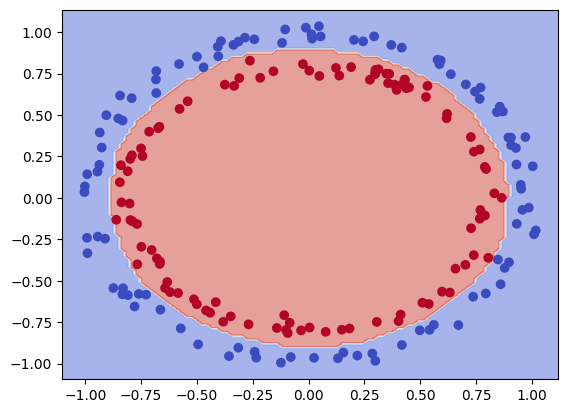

In [17]:
plot_decision_boundary(model_v2, X_test, y_test)

Loss Curve

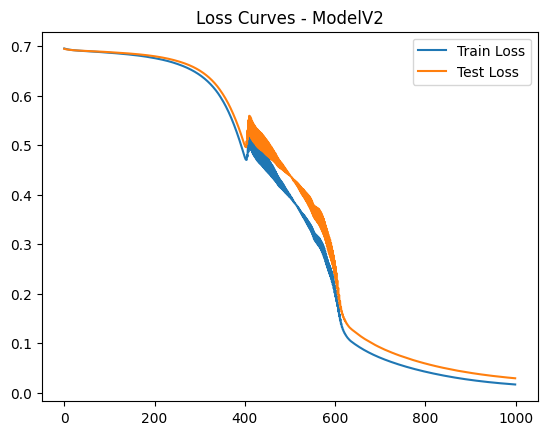

In [18]:
plt.plot(loss_v2, label="Train Loss")
plt.plot(test_loss_v2, label="Test Loss")
plt.legend()
plt.title("Loss Curves - ModelV2")
plt.show()

## Discussion and Conclusion
In this assignment, different neural network architectures were tested on a nonlinear circles dataset. The baseline models without activation functions performed poorly because they could only learn linear decision boundaries. Adding more layers alone did not significantly improve performance.
ModelV2, which included ReLU activation functions, successfully learned the circular pattern and achieved much higher accuracy. Additionally, Adam converged faster and more smoothly than SGD, showing the importance of optimizer choice in neural network training.<br>
This assignment showed that nonlinear activation functions are essential for solving nonlinearly separable problems. While simple linear models failed to classify the circular data accurately, deeper networks with ReLU achieved strong performance. Additionally, Adam provided faster and more stable convergence than SGD. Overall, the experiment reinforced key neural network concepts, including model architecture design, activation functions, loss handling, and optimizer selection.